In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        
        self.file_list = []

        # iterate through all subfolders (rex, tri, etc)
        for folder in os.listdir(root_dir):
            if folder == 'mis':
                continue
            folder_fp = os.path.join(root_dir, folder) 
            for img in os.listdir(folder_fp):
                self.file_list.append(os.path.join(folder_fp, img))

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = self.file_list[idx]
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        return image

# Define transformations to apply to your images
transform = transforms.Compose([
    # transforms.Resize((200, 200)), # not necessary, since images are already 200x200
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

current_dir = os.getcwd()
project_dir = os.path.dirname(current_dir)
images_dir = os.path.join(project_dir, 'images')

dataset = CustomDataset(root_dir = images_dir, transform=transform)

# Create a dataloader
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# # Iterate through the dataloader
# for batch_idx, batch in enumerate(dataloader):
#     # Use the batch of data here
#     print("Batch:", batch_idx)
#     print("Batch size:", len(batch))

#     # For example, you can access the images in the batch using batch[i]

In [12]:
# autoencoder code borrowed from patrickloeber: https://github.com/patrickloeber/pytorch-examples/blob/master/Autoencoder.ipynb

class Conv_AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__() 
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 4, stride = 3, padding = 1), # 32, 16, 67, 67
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, stride = 2, padding = 1),# 32, 32, 34, 34
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride = 2, padding = 1), # 32, 32, 17, 17
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 17 * 17, 3000),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3000, 32 * 17 * 17),
            nn.ReLU(),
            nn.Unflatten(dim = 1, unflattened_size=(32, 17, 17)),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride = 2, padding = 1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 3, stride = 2, padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 4, stride = 3, padding = 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [20]:
model = Conv_AutoEncoder()
model = model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-4, 
                             weight_decay=1e-6)

In [21]:
# Point to training loop video
num_epochs = 500
outputs = []
for epoch in range(num_epochs):
    for img in dataloader:
        img = img.to(device)
        # img = img.reshape(-1, 200*200)
        recon = model(img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.2133
Epoch:2, Loss:0.2132
Epoch:3, Loss:0.2119
Epoch:4, Loss:0.2115
Epoch:5, Loss:0.2110
Epoch:6, Loss:0.2089
Epoch:7, Loss:0.2064
Epoch:8, Loss:0.2032
Epoch:9, Loss:0.2005
Epoch:10, Loss:0.1962
Epoch:11, Loss:0.1947
Epoch:12, Loss:0.1903
Epoch:13, Loss:0.1890
Epoch:14, Loss:0.1853
Epoch:15, Loss:0.1836
Epoch:16, Loss:0.1810
Epoch:17, Loss:0.1789
Epoch:18, Loss:0.1759
Epoch:19, Loss:0.1749
Epoch:20, Loss:0.1722
Epoch:21, Loss:0.1697
Epoch:22, Loss:0.1678
Epoch:23, Loss:0.1665
Epoch:24, Loss:0.1643
Epoch:25, Loss:0.1633
Epoch:26, Loss:0.1621
Epoch:27, Loss:0.1611
Epoch:28, Loss:0.1593
Epoch:29, Loss:0.1576
Epoch:30, Loss:0.1561
Epoch:31, Loss:0.1547
Epoch:32, Loss:0.1536
Epoch:33, Loss:0.1513
Epoch:34, Loss:0.1510
Epoch:35, Loss:0.1490
Epoch:36, Loss:0.1483
Epoch:37, Loss:0.1463
Epoch:38, Loss:0.1451
Epoch:39, Loss:0.1439
Epoch:40, Loss:0.1430
Epoch:41, Loss:0.1411
Epoch:42, Loss:0.1404
Epoch:43, Loss:0.1388
Epoch:44, Loss:0.1374
Epoch:45, Loss:0.1364
Epoch:46, Loss:0.13

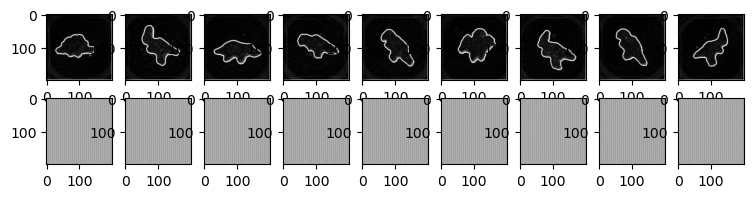

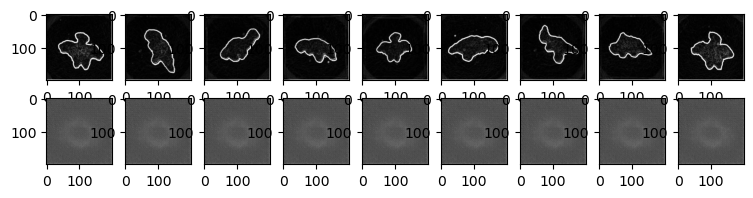

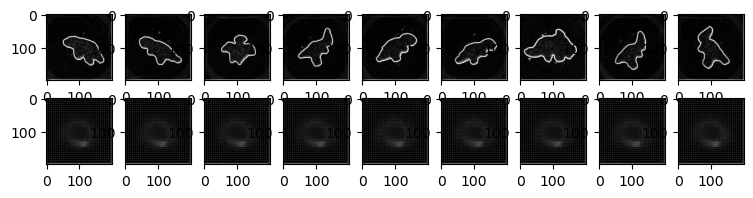

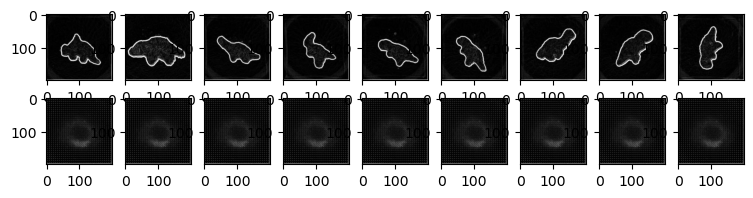

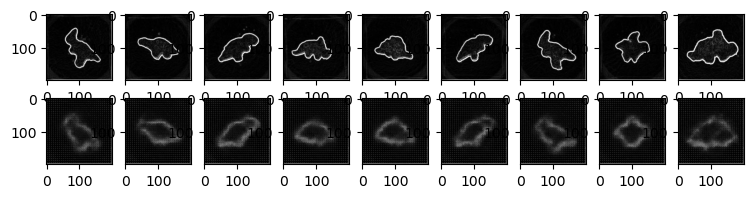

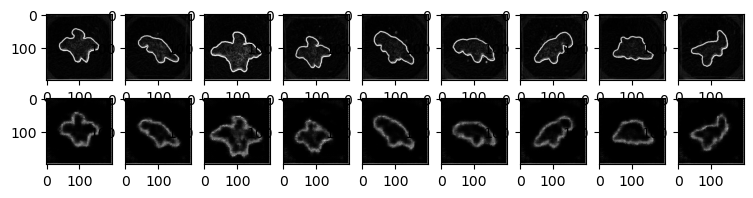

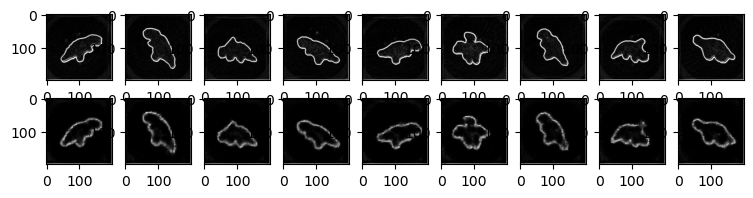

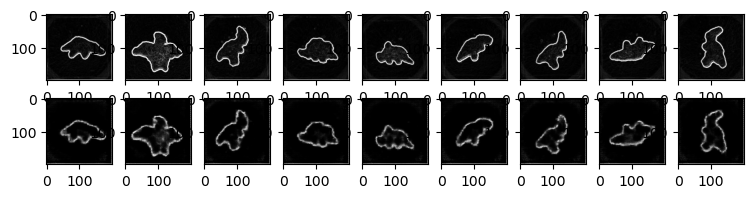

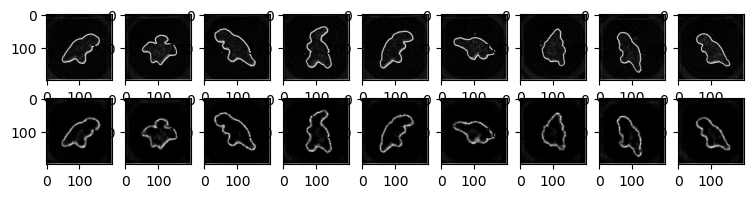

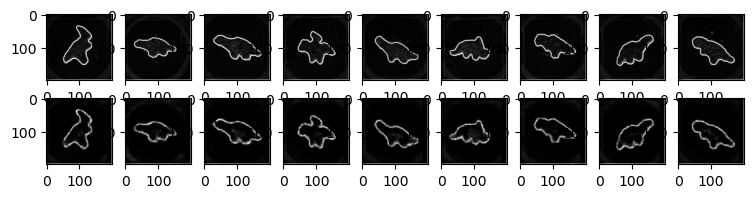

In [22]:
imgs = 0
for k in range(0, num_epochs, 50):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1]
    recon = outputs[k][2]
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item.view(200, 200).cpu().detach().numpy())
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item.view(200, 200).cpu().detach().numpy())

In [23]:
torch.save(model.state_dict(), 'conv_autoencoder_500_epochs.pth')

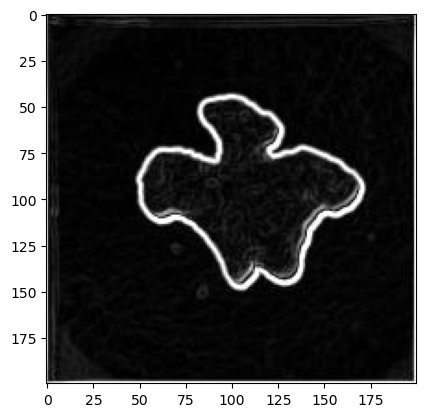

In [24]:
plt.imshow(outputs[-1][1][1].view(200, 200).cpu().detach().numpy())

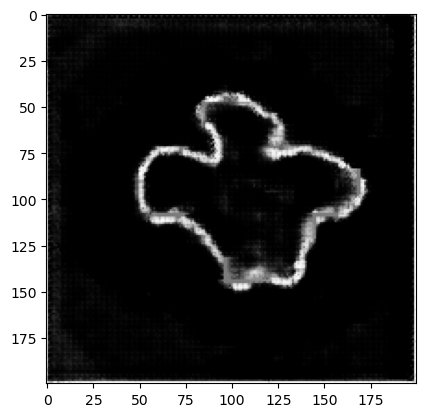

In [25]:
plt.imshow(outputs[-1][2][1].view(200, 200).cpu().detach().numpy())